In [9]:
# import zipfile

# with zipfile.ZipFile('autodl-pub/CelebA/Img/img_align_celeba.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [14]:
# HYPER PARAMETERS - for model_more_complicated.pth

input_dim = 3 * 64 * 64
hidden_dim = 4000  
latent_dim = 200   
dropout_rate = 0.5
num_epochs = 30

test_model_path = 'model_more_complicated.pth'
dataset_path = '../data/img_align_celeba'

In [24]:
# # HYPER PARAMETERS - for model_the_same_face.pth

# input_dim = 3 * 64 * 64
# hidden_dim = 400  
# latent_dim = 20  
# dropout_rate = 0.5
# num_epochs = 30

# test_model_path = 'model_the_same_face.pth'
# dataset_path = '../data/img_align_celeba'

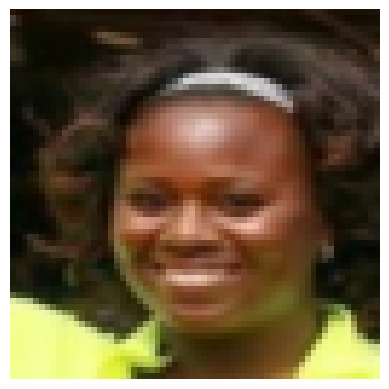

In [11]:
# CREATE DATASET

class CelebADataset(Dataset):
    def __init__(self, image_dir, transform=None):

        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, img_name)
        image = Image.open(image_path).convert('RGB')  

        if self.transform:
            image = self.transform(image)

        return image


transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
])

celebA_dataset = CelebADataset(image_dir=dataset_path, transform=transform)
celebA_dataloader = DataLoader(celebA_dataset, batch_size=128, shuffle=True)

# SHOW AN IMAGE
test = next(iter(celebA_dataloader))
test_img = test[0]
pil_image = ToPILImage()(test_img)

plt.imshow(pil_image)
plt.axis('off')  
plt.show()

In [25]:
# CREATE NETWORK

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mu
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # logvar

        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x):
        x = x.view(x.size(0), -1)
        h1 = torch.relu(self.fc1(x))
        h1 = self.dropout(h1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h3 = self.dropout(h3)
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



model = VAE(input_dim, hidden_dim, latent_dim, dropout_rate)

In [ ]:
# TRAIN

if torch.cuda.is_available():
    model.cuda() 

def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(model.parameters(), lr=1e-4)
stop_training = False

for epoch in range(num_epochs):
    train_loss = 0
    model.train()

    for batch_idx, x in enumerate(celebA_dataloader):
        optimizer.zero_grad()
        
        x = x.cuda()
        x = x.view(x.size(0), -1)  # 将x从(N, C, H, W)转换为(N, C*H*W)，改完后是32, 12288
        x_hat, mu, logvar = model(x) # x_hat也是32, 12288
        
        loss = loss_function(x_hat, x, mu, logvar)
        
        loss.backward()  # 反向传播计算梯度
        train_loss += loss.item()  # 累积训练损失
        optimizer.step()  # 更新模型参数

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss}')

    torch.save(model.state_dict(), f'model_new.pth')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(celebA_dataloader):.4f}')

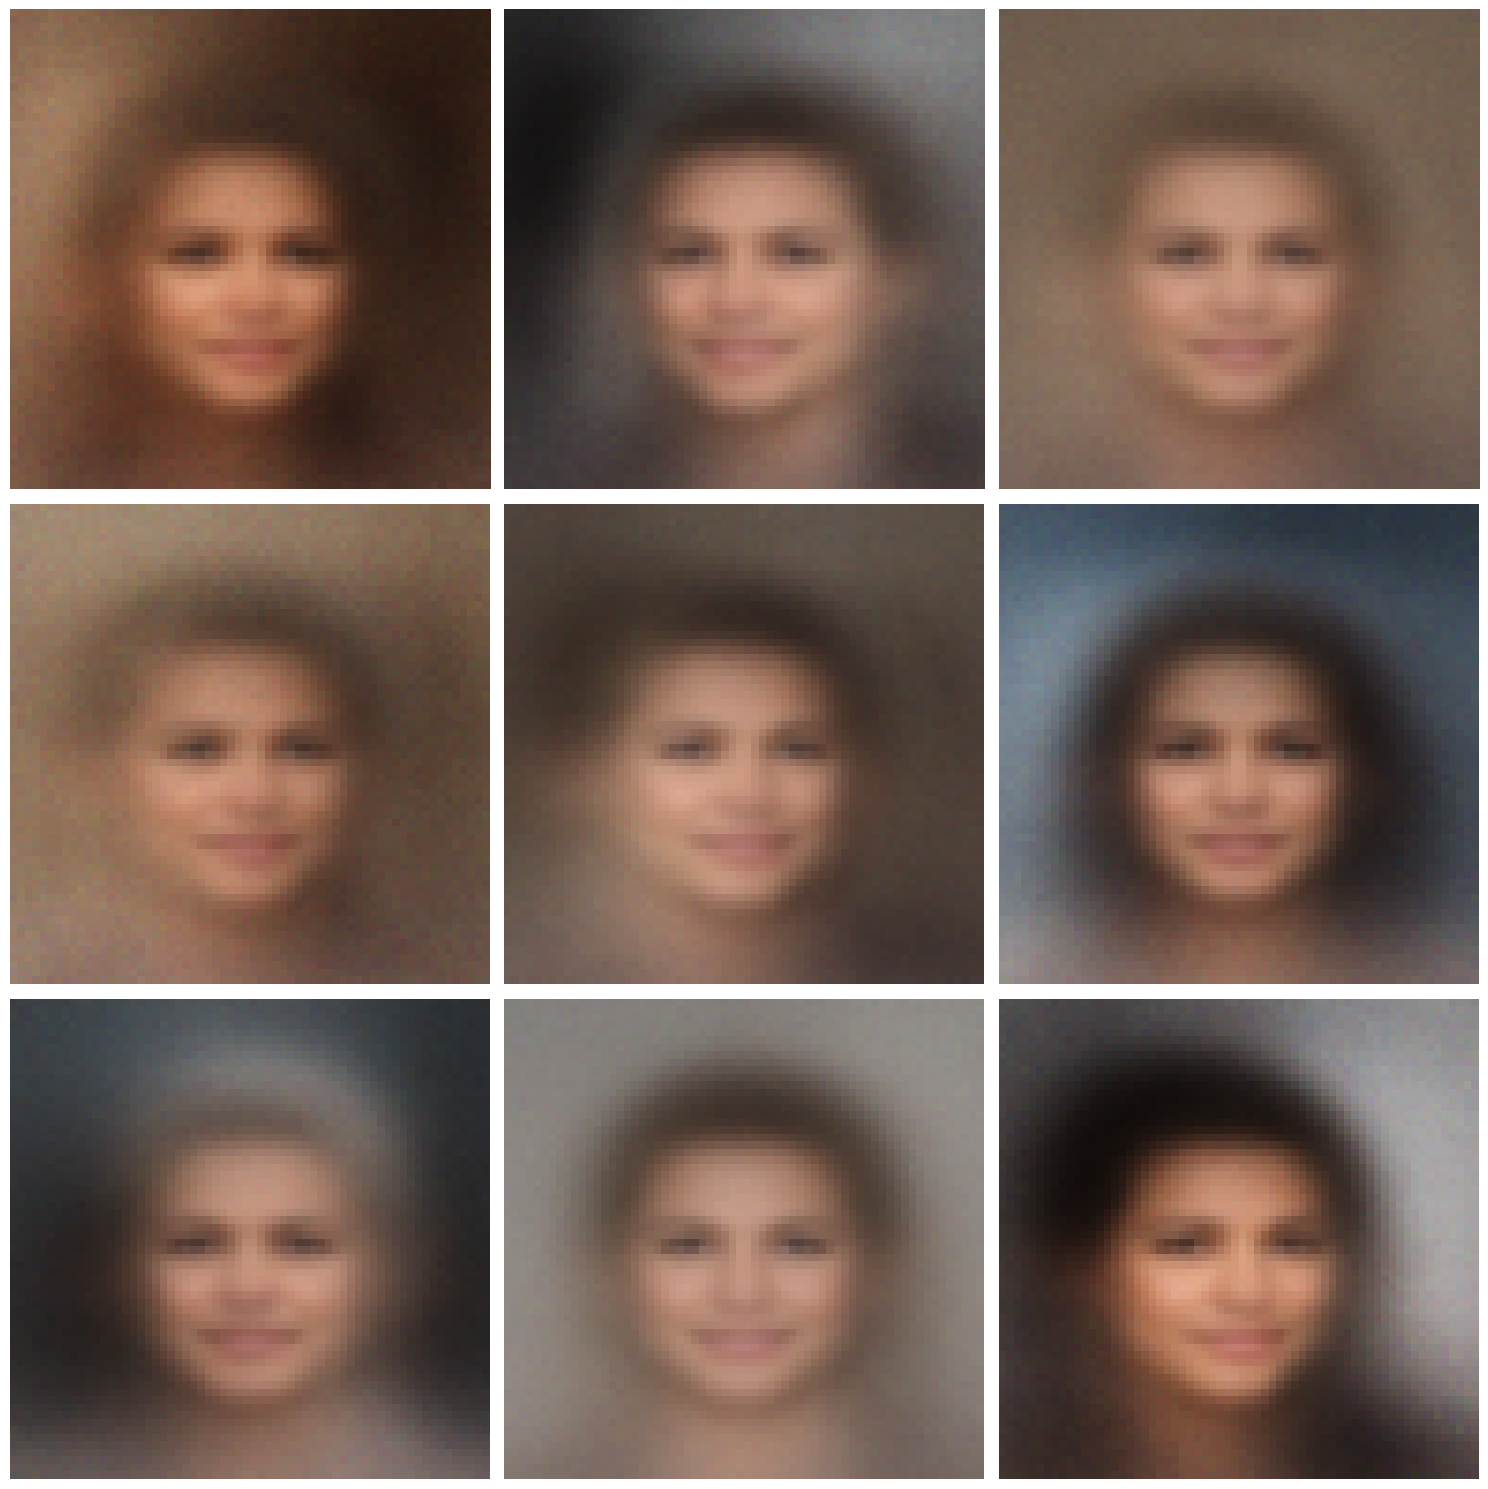

In [27]:
# TEST

model_params = torch.load(test_model_path)
model.load_state_dict(model_params)

model.cpu()
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(15, 15)) 

for i in range(9):
    z_sample = torch.randn(latent_dim)
    with torch.no_grad():
        generated_image = model.decode(z_sample).view(3, 64, 64)
    pil_image = ToPILImage()(generated_image)

    axs[i//3, i%3].imshow(pil_image)
    axs[i//3, i%3].axis('off')  

plt.tight_layout()
plt.show()

In [ ]:
# torch.save(model.state_dict(), f'model_the_same_face.pth')